<a href="https://colab.research.google.com/github/ApurvaMayank-iitb/24D0894_IE643_NIFTI/blob/main/mri_aotuencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the Autoencoder architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input channels = 1 (grayscale), output channels = 32
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample by 2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # Downsample by 2
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsample by 2
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),   # Upsample by 2, output channels = 1 (grayscale)
            nn.Sigmoid()  # Constrain the output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [2]:
from google.colab import files
uploaded = files.upload()


Saving BraTS20_Training_001_best_slice.npy to BraTS20_Training_001_best_slice.npy


In [3]:
import numpy as np

# After uploading, use the filename directly
best_slice = np.load('BraTS20_Training_001_best_slice.npy')
print(best_slice.shape)


(256, 256)


In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import cv2

# Load the preprocessed best slice from the .npy file

processed_data_path = 'BraTS20_Training_001_best_slice.npy'

best_slice = np.load(processed_data_path)

# Convert the slice to a PyTorch tensor
best_slice_tensor = torch.tensor(best_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Data augmentation: create augmented versions of the slice (e.g., flipping, rotating)
def augment_slice(slice_tensor):
    augmented_slices = [slice_tensor]  # Original slice

    # Add different augmentations
    augmented_slices.append(torch.flip(slice_tensor, [2]))  # Horizontal flip
    augmented_slices.append(torch.flip(slice_tensor, [3]))  # Vertical flip
    augmented_slices.append(torch.rot90(slice_tensor, 1, [2, 3]))  # 90 degree rotation
    augmented_slices.append(torch.rot90(slice_tensor, 2, [2, 3]))  # 180 degree rotation

    return torch.cat(augmented_slices, dim=0)  # Stack augmented slices into a single tensor

# Augment the data
augmented_slices = augment_slice(best_slice_tensor)

# Create a DataLoader for batch processing
dataset = TensorDataset(augmented_slices, augmented_slices)  # Input = Target (since Autoencoder)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)


In [5]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder: Downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample by 2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # Downsample by 2
        )

        # Decoder: Upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsample by 2
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),   # Upsample by 2
            nn.Sigmoid()  # Output constrained between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = ConvAutoencoder()


In [6]:
import numpy as np
import torch

# Load the preprocessed slice from your uploaded file
processed_data_path = 'BraTS20_Training_001_best_slice.npy'  # Adjust the path if needed
best_slice = np.load(processed_data_path)

# Convert the slice to a PyTorch tensor and add batch and channel dimensions
best_slice_tensor = torch.tensor(best_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]

# Move the data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_slice_tensor = best_slice_tensor.to(device)

print(f"Loaded slice shape: {best_slice_tensor.shape}")  # Should be [1, 1, H, W]


Loaded slice shape: torch.Size([1, 1, 256, 256])


In [7]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Move the model to the correct device (GPU/CPU)
model.to(device)

# Training loop
num_epochs = 50  # Adjust if necessary
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(best_slice_tensor)

    # Calculate loss
    loss = criterion(outputs, best_slice_tensor)  # The target is the original slice itself

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")


Epoch [1/50], Loss: 0.163087
Epoch [2/50], Loss: 0.160564
Epoch [3/50], Loss: 0.158171
Epoch [4/50], Loss: 0.155736
Epoch [5/50], Loss: 0.153293
Epoch [6/50], Loss: 0.150879
Epoch [7/50], Loss: 0.148410
Epoch [8/50], Loss: 0.145717
Epoch [9/50], Loss: 0.142866
Epoch [10/50], Loss: 0.139889
Epoch [11/50], Loss: 0.136786
Epoch [12/50], Loss: 0.133504
Epoch [13/50], Loss: 0.130032
Epoch [14/50], Loss: 0.126336
Epoch [15/50], Loss: 0.122427
Epoch [16/50], Loss: 0.118316
Epoch [17/50], Loss: 0.114074
Epoch [18/50], Loss: 0.109654
Epoch [19/50], Loss: 0.105054
Epoch [20/50], Loss: 0.100362
Epoch [21/50], Loss: 0.095593
Epoch [22/50], Loss: 0.090789
Epoch [23/50], Loss: 0.085967
Epoch [24/50], Loss: 0.081167
Epoch [25/50], Loss: 0.076422
Epoch [26/50], Loss: 0.071773
Epoch [27/50], Loss: 0.067227
Epoch [28/50], Loss: 0.062794
Epoch [29/50], Loss: 0.058488
Epoch [30/50], Loss: 0.054346
Epoch [31/50], Loss: 0.050383
Epoch [32/50], Loss: 0.046603
Epoch [33/50], Loss: 0.043004
Epoch [34/50], Loss

In [8]:
# Put the model in evaluation mode
model.eval()

# Disable gradient calculations for faster inference
with torch.no_grad():
    reconstructed_slice = model(best_slice_tensor)

# Move the reconstructed slice back to CPU for further processing
reconstructed_slice = reconstructed_slice.cpu()

# Calculate reconstruction error (absolute difference)
reconstruction_error = torch.abs(reconstructed_slice - best_slice_tensor.cpu())


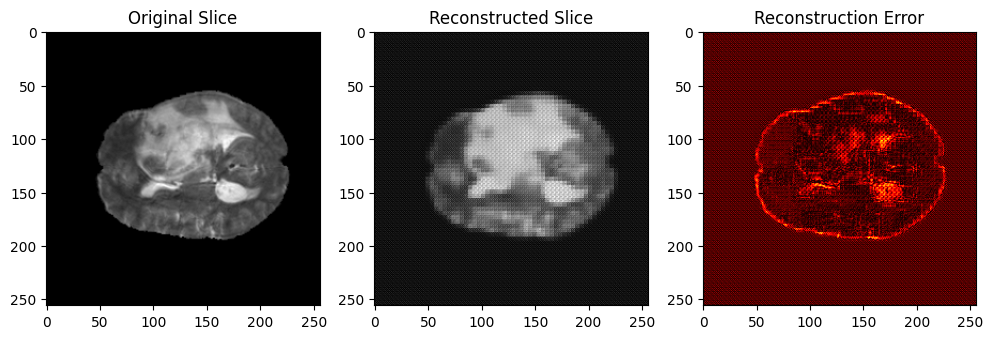

In [9]:
import matplotlib.pyplot as plt

# Convert tensors back to numpy for plotting
original_slice_np = best_slice_tensor.squeeze().cpu().numpy()  # Original slice
reconstructed_slice_np = reconstructed_slice.squeeze().cpu().numpy()  # Reconstructed slice
reconstruction_error_np = reconstruction_error.squeeze().cpu().numpy()  # Reconstruction error

# Plot the original, reconstructed, and error images
plt.figure(figsize=(12, 4))

# Plot original slice
plt.subplot(1, 3, 1)
plt.title("Original Slice")
plt.imshow(original_slice_np, cmap='gray')

# Plot reconstructed slice
plt.subplot(1, 3, 2)
plt.title("Reconstructed Slice")
plt.imshow(reconstructed_slice_np, cmap='gray')

# Plot reconstruction error
plt.subplot(1, 3, 3)
plt.title("Reconstruction Error")
plt.imshow(reconstruction_error_np, cmap='hot')

plt.show()


Saving BraTS20_Validation_002_t1ce.nii to BraTS20_Validation_002_t1ce.nii
Saving BraTS20_Validation_002_t2.nii to BraTS20_Validation_002_t2.nii
File BraTS20_Validation_002_t1ce.nii uploaded successfully!
File BraTS20_Validation_002_t2.nii uploaded successfully!
Anomaly Found!


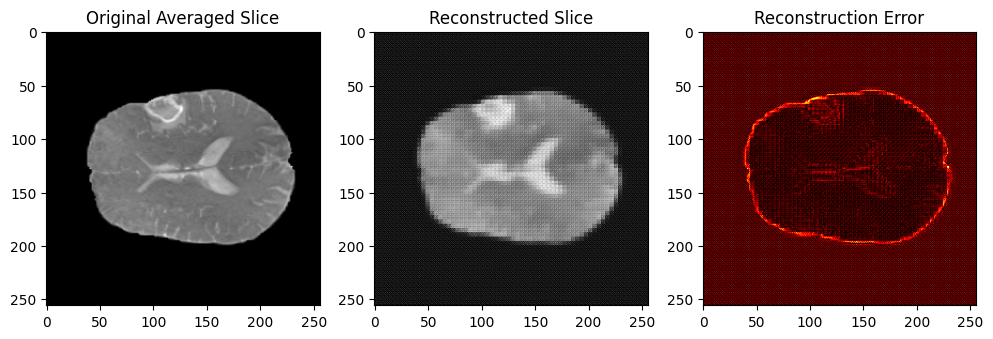

TypeError: abs(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [10]:
from google.colab import files
import nibabel as nib
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

# Step 1: Upload multiple .nii files (modalities) for evaluation
def upload_nii_files():
    """
    Use Google Colab to upload multiple .nii files (excluding segmentation files).
    """
    uploaded = files.upload()  # This will prompt the user to upload multiple .nii files
    modalities = {}  # Dictionary to store the modalities

    for filename in uploaded.keys():
        if 'seg' not in filename.lower():  # Exclude segmentation files
            print(f"File {filename} uploaded successfully!")
            modalities[filename] = filename  # Store the filenames of modalities

    return modalities

# Step 2: Load and preprocess the modalities, and average them into a single channel
def load_and_average_modalities(modalities, slice_axis=2, target_size=(256, 256)):
    """
    Load multiple .nii files (modalities), extract the best slice from each,
    preprocess, and average them into a single channel.
    """
    processed_slices = []

    # Process each modality
    for modality_name, file_path in modalities.items():
        # Load the .nii file
        img = nib.load(file_path)
        data = img.get_fdata()  # Convert to numpy array

        # Extract slices along the desired axis (default is the axial view, axis=2)
        slices = [data.take(i, axis=slice_axis) for i in range(data.shape[slice_axis])]

        # Find the slice with the maximum non-zero pixels
        non_zero_counts = [np.count_nonzero(slice_) for slice_ in slices]
        max_index = np.argmax(non_zero_counts)  # Index of the slice with the most non-zero pixels
        best_slice = slices[max_index]

        # Resize the slice to the target size (e.g., 256x256)
        best_slice_resized = cv2.resize(best_slice, target_size)

        # Normalize the slice to the range [0, 1]
        best_slice_normalized = best_slice_resized / np.max(best_slice_resized) if np.max(best_slice_resized) > 0 else best_slice_resized

        # Append the preprocessed slice to the list
        processed_slices.append(best_slice_normalized)

    # Average the slices from different modalities to get a single-channel image
    averaged_slice = np.mean(processed_slices, axis=0)  # Average across modalities

    return averaged_slice

# Step 3: Convert the preprocessed single-channel slice to a PyTorch tensor
def slice_to_tensor(slice_np, device):
    """
    Convert the preprocessed numpy slice into a PyTorch tensor.
    """
    slice_tensor = torch.tensor(slice_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions
    return slice_tensor

# Step 4: Evaluate the autoencoder and check for anomalies
def evaluate_anomaly(model, modalities, device, threshold_multiplier=1):
    """
    Evaluate a new sample (in .nii format with multiple modalities) and detect anomalies.
    """
    # Load and average the modalities into a single channel
    averaged_slice = load_and_average_modalities(modalities)

    # Convert the averaged slice to a PyTorch tensor
    slice_tensor = slice_to_tensor(averaged_slice, device)

    # Put the model in evaluation mode
    model.eval()

    # Perform the evaluation and get the reconstructed output
    with torch.no_grad():  # Disable gradients
        reconstructed_slice = model(slice_tensor)

    # Calculate the reconstruction error
    reconstruction_error = torch.abs(reconstructed_slice - slice_tensor.cpu())

    # Flatten the reconstruction error to calculate the threshold
    reconstruction_error_np = reconstruction_error.squeeze().cpu().numpy()
    error_flat = reconstruction_error_np.flatten()

    # Define a threshold (mean + threshold_multiplier * std deviation)
    threshold = np.mean(error_flat) + threshold_multiplier * np.std(error_flat)

    # Check if any pixel's error exceeds the threshold
    anomalous_pixels = error_flat > threshold
    if np.any(anomalous_pixels):
        print("Anomaly Found!")
    else:
        print("No Anomaly Found!")

    # Return the original averaged slice, reconstructed slice, and reconstruction error for visualization
    return averaged_slice, reconstructed_slice.squeeze().cpu().numpy(), reconstruction_error_np

# Step 5: Visualize the results
def visualize_results(original_slice, reconstructed_slice, reconstruction_error):
    """
    Visualize the original slice, reconstructed slice, and the reconstruction error.
    """
    plt.figure(figsize=(12, 4))

    # Plot original slice
    plt.subplot(1, 3, 1)
    plt.title("Original Averaged Slice")
    plt.imshow(original_slice, cmap='gray')

    # Plot reconstructed slice
    plt.subplot(1, 3, 2)
    plt.title("Reconstructed Slice")
    plt.imshow(reconstructed_slice, cmap='gray')

    # Plot reconstruction error
    plt.subplot(1, 3, 3)
    plt.title("Reconstruction Error")
    plt.imshow(reconstruction_error, cmap='hot')

    plt.show()

# Main: Upload multiple .nii files and perform anomaly detection
modalities = upload_nii_files()

# Device setup (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate the uploaded .nii files (modalities)
original_slice, reconstructed_slice, reconstruction_error = evaluate_anomaly(model, modalities, device)

# Visualize the results
visualize_results(original_slice, reconstructed_slice, reconstruction_error)

import numpy as np
import torch

# Step 1: Calculate reconstruction error (absolute difference between original and reconstructed slices)
reconstruction_error = torch.abs(reconstructed_slice - original_slice)
reconstruction_error_np = reconstruction_error.squeeze().cpu().numpy()

# Step 2: Calculate mean and standard deviation of the reconstruction error to define a dynamic threshold
mean_error = np.mean(reconstruction_error_np)
std_dev_error = np.std(reconstruction_error_np)
threshold = mean_error + 1 * std_dev_error  # Experiment with different multipliers like 1, 1.5, or 2

# Step 3: Identify anomalous pixels above the threshold
anomalous_pixels = reconstruction_error_np > threshold
num_anomalous_pixels = np.sum(anomalous_pixels)
total_pixels = reconstruction_error_np.size

# Calculate the anomalous ratio
anomalous_ratio = num_anomalous_pixels / total_pixels
print(f"Anomalous pixels ratio: {anomalous_ratio:.4f}")

# Step 4: Make a decision based on the ratio of anomalous pixels
cutoff_ratio = 0.05  # Adjust this based on results

if anomalous_ratio > cutoff_ratio:
    print("Tumor Found!")
else:
    print("No Tumor Found.")


Saving BraTS20_Validation_002_t1ce.nii to BraTS20_Validation_002_t1ce (1).nii
Saving BraTS20_Validation_002_t2.nii to BraTS20_Validation_002_t2 (1).nii
File BraTS20_Validation_002_t1ce (1).nii uploaded successfully!
File BraTS20_Validation_002_t2 (1).nii uploaded successfully!
Anomalous pixels ratio: 0.1579
Tumor Found!


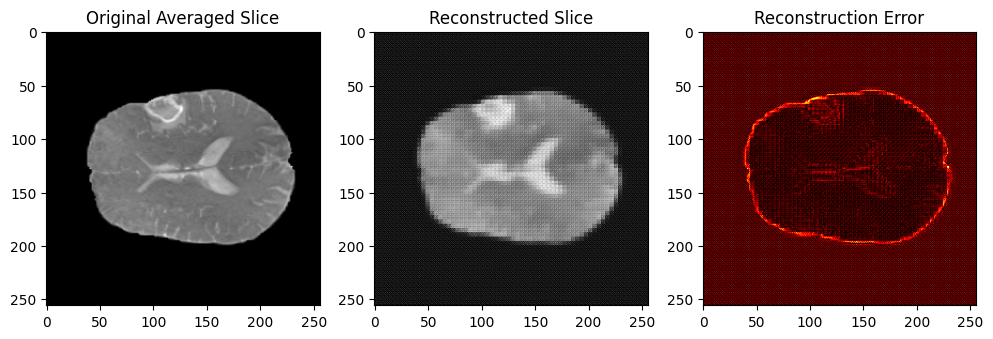

In [11]:
from google.colab import files
import nibabel as nib
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

# Step 1: Upload multiple .nii files (modalities) for evaluation
def upload_nii_files():
    """
    Use Google Colab to upload multiple .nii files (excluding segmentation files).
    """
    uploaded = files.upload()  # This will prompt the user to upload multiple .nii files
    modalities = {}  # Dictionary to store the modalities

    for filename in uploaded.keys():
        if 'seg' not in filename.lower():  # Exclude segmentation files
            print(f"File {filename} uploaded successfully!")
            modalities[filename] = filename  # Store the filenames of modalities

    return modalities

# Step 2: Load and preprocess the modalities, and average them into a single channel
def load_and_average_modalities(modalities, slice_axis=2, target_size=(256, 256)):
    """
    Load multiple .nii files (modalities), extract the best slice from each,
    preprocess, and average them into a single channel.
    """
    processed_slices = []

    for modality_name, file_path in modalities.items():
        # Load the .nii file
        img = nib.load(file_path)
        data = img.get_fdata()

        # Extract slices along the desired axis and find the slice with maximum non-zero pixels
        slices = [data.take(i, axis=slice_axis) for i in range(data.shape[slice_axis])]
        non_zero_counts = [np.count_nonzero(slice_) for slice_ in slices]
        max_index = np.argmax(non_zero_counts)  # Slice with the most non-zero pixels
        best_slice = slices[max_index]

        # Resize and normalize the slice
        best_slice_resized = cv2.resize(best_slice, target_size)
        best_slice_normalized = best_slice_resized / np.max(best_slice_resized) if np.max(best_slice_resized) > 0 else best_slice_resized

        processed_slices.append(best_slice_normalized)

    # Average the slices from different modalities
    averaged_slice = np.mean(processed_slices, axis=0)

    return averaged_slice

# Step 3: Convert the preprocessed single-channel slice to a PyTorch tensor
def slice_to_tensor(slice_np, device):
    """
    Convert the preprocessed numpy slice into a PyTorch tensor.
    """
    slice_tensor = torch.tensor(slice_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    return slice_tensor

# Step 4: Evaluate the autoencoder and check for anomalies
def evaluate_anomaly(model, slice_tensor, threshold_multiplier=1, cutoff_ratio=0.05):
    """
    Evaluate the given tensor for anomalies using the trained model.
    """
    model.eval()
    with torch.no_grad():
        reconstructed_slice = model(slice_tensor)

    # Calculate the reconstruction error
    reconstruction_error = torch.abs(reconstructed_slice - slice_tensor).squeeze().cpu().numpy()

    # Define a threshold based on mean + threshold_multiplier * std deviation
    mean_error = np.mean(reconstruction_error)
    std_dev_error = np.std(reconstruction_error)
    threshold = mean_error + threshold_multiplier * std_dev_error

    # Determine if any pixel exceeds the threshold
    anomalous_pixels = reconstruction_error > threshold
    anomalous_ratio = np.sum(anomalous_pixels) / reconstruction_error.size
    result_message = "Tumor Found!" if anomalous_ratio > cutoff_ratio else "No Tumor Found."

    print(f"Anomalous pixels ratio: {anomalous_ratio:.4f}")
    print(result_message)

    return result_message, reconstruction_error, reconstructed_slice.squeeze().cpu().numpy()

# Step 5: Visualize the results
def visualize_results(original_slice, reconstructed_slice, reconstruction_error):
    """
    Visualize the original slice, reconstructed slice, and the reconstruction error.
    """
    plt.figure(figsize=(12, 4))

    # Plot original slice
    plt.subplot(1, 3, 1)
    plt.title("Original Averaged Slice")
    plt.imshow(original_slice, cmap='gray')

    # Plot reconstructed slice
    plt.subplot(1, 3, 2)
    plt.title("Reconstructed Slice")
    plt.imshow(reconstructed_slice, cmap='gray')

    # Plot reconstruction error
    plt.subplot(1, 3, 3)
    plt.title("Reconstruction Error")
    plt.imshow(reconstruction_error, cmap='hot')

    plt.show()

# Main Function for Anomaly Detection Pipeline
def anomaly_detection_pipeline(modalities, model, device, threshold_multiplier=1, cutoff_ratio=0.05):
    """
    Full pipeline for loading, preprocessing, anomaly detection, and visualization.
    """
    # Step A: Load and preprocess modalities
    averaged_slice = load_and_average_modalities(modalities)

    # Step B: Convert the averaged slice to a PyTorch tensor
    slice_tensor = slice_to_tensor(averaged_slice, device)

    # Step C: Perform anomaly detection
    result_message, reconstruction_error, reconstructed_slice = evaluate_anomaly(
        model, slice_tensor, threshold_multiplier, cutoff_ratio
    )

    # Step D: Visualize the results
    visualize_results(averaged_slice, reconstructed_slice, reconstruction_error)

# Device setup (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load or define the model (assuming 'model' is already loaded and trained)
# model = ... (load or define your trained autoencoder model here)

# Upload and evaluate modalities
modalities = upload_nii_files()
anomaly_detection_pipeline(modalities, model, device)
